In [1]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=1db2ca2c6f678eec5afa36499e9d28f3649c1b1c49ad89446ff95e6005942205
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [2]:
# import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

MAX_MEMORY = "12g"
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", MAX_MEMORY) \
  .config("spark.driver.memory", MAX_MEMORY)\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size",MAX_MEMORY)\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
train_df = spark.read.format("csv").option("header", "true").load("train.csv")
train_df.take(5)

[Row(id='1', Gender='Male', Age='44', Driving_License='1', Region_Code='28.0', Previously_Insured='0', Vehicle_Age='> 2 Years', Vehicle_Damage='Yes', Annual_Premium='40454.0', Policy_Sales_Channel='26.0', Vintage='217', Response='1'),
 Row(id='2', Gender='Male', Age='76', Driving_License='1', Region_Code='3.0', Previously_Insured='0', Vehicle_Age='1-2 Year', Vehicle_Damage='No', Annual_Premium='33536.0', Policy_Sales_Channel='26.0', Vintage='183', Response='0'),
 Row(id='3', Gender='Male', Age='47', Driving_License='1', Region_Code='28.0', Previously_Insured='0', Vehicle_Age='> 2 Years', Vehicle_Damage='Yes', Annual_Premium='38294.0', Policy_Sales_Channel='26.0', Vintage='27', Response='1'),
 Row(id='4', Gender='Male', Age='21', Driving_License='1', Region_Code='11.0', Previously_Insured='1', Vehicle_Age='< 1 Year', Vehicle_Damage='No', Annual_Premium='28619.0', Policy_Sales_Channel='152.0', Vintage='203', Response='0'),
 Row(id='5', Gender='Female', Age='29', Driving_License='1', Regi

In [4]:
from pyspark.sql.functions import *
train_df = train_df.drop('id')
display(train_df.toPandas().head())

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


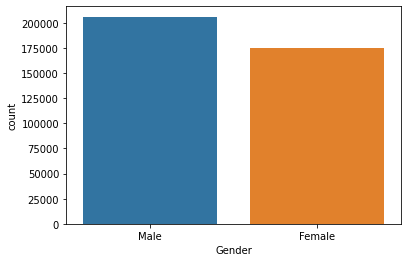

In [6]:
import seaborn as sns
train_pd_df = train_df.toPandas()
sns.countplot(train_pd_df.Gender)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


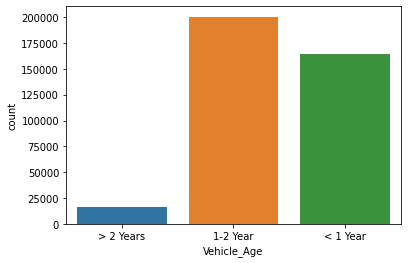

In [7]:
sns.countplot(train_pd_df.Vehicle_Age)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


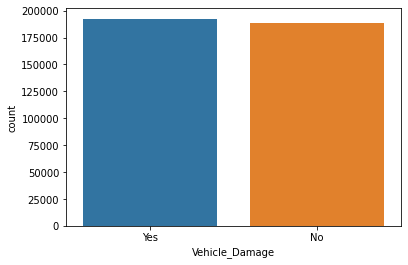

In [8]:
sns.countplot(train_pd_df.Vehicle_Damage)

In [9]:
train_df = train_df.withColumn("Gender", when(train_df.Gender == 'Male', 1).otherwise(0))
train_df = train_df.withColumn("Vehicle_Damage", when(train_df.Vehicle_Damage == 'Yes', 1).otherwise(0))
train_df = train_df.withColumn("Vehicle_Age", when(train_df.Vehicle_Age == '> 2 Years', 2).when(train_df.Vehicle_Age == '1-2 Year', 1).otherwise(0))

In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StringIndexerModel

indexer_1 = StringIndexerModel.from_labels(['Female', 'Male'], inputCol="Gender", outputCol="Gender_idx")
indexer_2 = StringIndexerModel.from_labels(['No', 'Yes'], inputCol="Vehicle_Damage", outputCol="Vehicle_Damage_idx")
indexer_3 = StringIndexerModel.from_labels(['< 1 Year', '1-2 Year', '> 2 Years'], inputCol="Vehicle_Age", outputCol="Vehicle_Age_idx")

feature_engineering_pipe = Pipeline(stages=[indexer_1, indexer_2, indexer_3])
temp_df = feature_engineering_pipe.fit(train_df).transform(train_df)
columns_to_drop = ['Gender', 'Vehicle_Damage', 'Vehicle_Age']
temp_df = temp_df.drop(*columns_to_drop)
train_df_new = temp_df.withColumnRenamed("Gender_idx", "Gender").withColumnRenamed("Vehicle_Damage_idx", "Vehicle_Damage").withColumnRenamed("Vehicle_Age_idx", "Vehicle_Age")

In [23]:
display(train_df_new.toPandas().head())

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender,Vehicle_Damage,Vehicle_Age
0,44.0,1.0,28.0,0.0,40454.0,26.0,217.0,1.0,1.0,1.0,2.0
1,76.0,1.0,3.0,0.0,33536.0,26.0,183.0,0.0,1.0,0.0,1.0
2,47.0,1.0,28.0,0.0,38294.0,26.0,27.0,1.0,1.0,1.0,2.0
3,21.0,1.0,11.0,1.0,28619.0,152.0,203.0,0.0,1.0,0.0,0.0
4,29.0,1.0,41.0,1.0,27496.0,152.0,39.0,0.0,0.0,0.0,0.0


In [7]:
train_df_new.dtypes

[('Age', 'string'),
 ('Driving_License', 'string'),
 ('Region_Code', 'string'),
 ('Previously_Insured', 'string'),
 ('Annual_Premium', 'string'),
 ('Policy_Sales_Channel', 'string'),
 ('Vintage', 'string'),
 ('Response', 'string'),
 ('Gender', 'double'),
 ('Vehicle_Damage', 'double'),
 ('Vehicle_Age', 'double')]

In [8]:
#from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

train_df_new = train_df_new.withColumn("Age", train_df_new["Age"].cast(DoubleType()))
train_df_new = train_df_new.withColumn("Driving_License", train_df_new["Driving_License"].cast(DoubleType()))
train_df_new = train_df_new.withColumn("Region_Code", train_df_new["Region_Code"].cast(DoubleType()))
train_df_new = train_df_new.withColumn("Previously_Insured", train_df_new["Previously_Insured"].cast(DoubleType()))
train_df_new = train_df_new.withColumn("Annual_Premium", train_df_new["Annual_Premium"].cast(DoubleType()))
train_df_new = train_df_new.withColumn("Policy_Sales_Channel", train_df_new["Policy_Sales_Channel"].cast(DoubleType()))
train_df_new = train_df_new.withColumn("Vintage", train_df_new["Vintage"].cast(DoubleType()))
train_df_new = train_df_new.withColumn("Response", train_df_new["Response"].cast(DoubleType()))

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
#train_df.dtypes
vecAssembler = VectorAssembler(inputCols=['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'], outputCol="features")
#train_df = vecAssembler.transform(train_df)
sc = StandardScaler(withMean=True, withStd=True, inputCol='features')

In [10]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


evaluator = BinaryClassificationEvaluator(labelCol="Response", metricName="areaUnderROC")

In [35]:
training_df, testing_df = train_df_new2.randomSplit([0.7, 0.3])

In [46]:
#RF
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Response", featuresCol="features")

rf_pipeline = Pipeline(stages=[vecAssembler, rf]).fit(training_df)
rf_model = rf_pipeline.transform(testing_df)

In [47]:
print(evaluator.evaluate(rf_model))

0.8458061120250483


In [ ]:
feature_importances = rf_pipeline.stages[-1].featureImportances
feature_imp_array = feature_importances.toArray()

In [ ]:
print(feature_imp_array)

In [ ]:
predictors = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(predictors, feature_imp_array):
    feats[feature] = importance

In [ ]:
import pandas as pd

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, title='RF feature importance')

In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

#actual = rf_model_pd['Response'].tolist()
#pred = rf_model_pd['prediction'].tolist()

y_true = rf_model.select(['Response']).collect()
y_pred = rf_model.select(['prediction']).collect()

#print(classification_report(actual, pred))
#print(precision_score(actual, pred))
print(classification_report(y_true, y_pred))

In [14]:
pip install imblearn

In [16]:
from collections import Counter
print(Counter(testing_df))

TypeError: ignored

In [25]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')


In [24]:
X = train_df_new.toPandas().filter(items=['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Gender', 'Vehicle_Damage', 'Vehicle_Age'])
Y = train_df_new.toPandas().filter(items=['Response'])
print(X.shape)
print(Y.shape)

(381109, 10)
(381109, 1)


In [20]:
X = training_df.toPandas().to_numpy()
y = testing_df.toPandas().to_numpy()

In [26]:
#type(X)
X_under, y_under = undersample.fit_resample(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [32]:
#len(X_under)
import pandas as pd

dataframe_1 = pd.DataFrame(X_under, columns=['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Gender', 'Vehicle_Damage', 'Vehicle_Age'])
dataframe_2 = pd.DataFrame(y_under, columns = ['Response'])
result_df = dataframe_1.combine_first(dataframe_2)

In [45]:
#train_df_new2 = spark.createDataFrame(result_df)
train_df_new2.dtypes
len(result_df[result_df['Response'] == 1.0])

46710

In [48]:
##DT
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="Response", featuresCol="features")
#dt_model = dt.fit(training_df)
#dt_predict = dt_model.transform(testing_df)
dt_pipeline = Pipeline(stages=[vecAssembler, dt]).fit(training_df)
dt_model = dt_pipeline.transform(testing_df)
print(evaluator.evaluate(dt_model))

0.8149665398832767


In [49]:
#LR
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Response", featuresCol="features")

lr_pipeline = Pipeline(stages=[vecAssembler, lr]).fit(training_df)
lr_model = lr_pipeline.transform(testing_df)
print(evaluator.evaluate(lr_model))

0.8315742880907778


In [50]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

rf_y_true = rf_model.select(['Response']).collect()
rf_y_pred = rf_model.select(['prediction']).collect()

print(classification_report(rf_y_true, rf_y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.65      0.76     13815
         1.0       0.73      0.93      0.82     13884

    accuracy                           0.79     27699
   macro avg       0.82      0.79      0.79     27699
weighted avg       0.82      0.79      0.79     27699



In [51]:
dt_y_true = dt_model.select(['Response']).collect()
dt_y_pred = dt_model.select(['prediction']).collect()

print(classification_report(dt_y_true, dt_y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.67      0.76     13815
         1.0       0.74      0.91      0.81     13884

    accuracy                           0.79     27699
   macro avg       0.81      0.79      0.79     27699
weighted avg       0.81      0.79      0.79     27699



In [52]:
lr_y_true = lr_model.select(['Response']).collect()
lr_y_pred = lr_model.select(['prediction']).collect()

print(classification_report(lr_y_true, lr_y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.59      0.73     13815
         1.0       0.71      0.98      0.82     13884

    accuracy                           0.78     27699
   macro avg       0.83      0.78      0.78     27699
weighted avg       0.83      0.78      0.78     27699



In [53]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10,labelCol='Response', featuresCol='features')

gbt_pipeline = Pipeline(stages=[vecAssembler, gbt]).fit(training_df)
gbt_model = gbt_pipeline.transform(testing_df)
print(evaluator.evaluate(gbt_model))

0.8491883136349335


In [54]:
gbt_y_true = gbt_model.select(['Response']).collect()
gbt_y_pred = gbt_model.select(['prediction']).collect()

print(classification_report(gbt_y_true, gbt_y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.65      0.76     13815
         1.0       0.73      0.94      0.82     13884

    accuracy                           0.79     27699
   macro avg       0.82      0.79      0.79     27699
weighted avg       0.82      0.79      0.79     27699



In [55]:
rf_estimator = Pipeline(stages=[vecAssembler, rf])

In [58]:
import numpy as np
from pyspark.ml.tuning import ParamGridBuilder

enable_grid_search = True
if enable_grid_search:
  grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 15, 20, 25, 30]).addGrid(rf.maxDepth, [5, 10, 15]).addGrid(rf.maxBins, [10, 20, 30]).build()
  all_models = []
  for i in range(len(grid)):
    model = rf_estimator.fit(training_df, grid[i])
    all_models.append(model)
  auc = []
  for m in all_models:
    new_rf_model = m.transform(testing_df)
    auc.append(evaluator.evaluate(new_rf_model))
  best_model_idx = np.argmax(auc)
  print("best model index =", best_model_idx)
  print(grid[best_model_idx])
  pass

#25, 10, 30

best model index = 32
{Param(parent='RandomForestClassifier_5dacac8edead', name='numTrees', doc='Number of trees to train (>= 1).'): 25, Param(parent='RandomForestClassifier_5dacac8edead', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='RandomForestClassifier_5dacac8edead', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 30}


In [59]:
#optimal RF model
num_trees = 25
max_depth = 10
max_bins = 30

optimal_rf = RandomForestClassifier().setLabelCol('Response').setFeaturesCol('features').setNumTrees(num_trees).setMaxDepth(max_depth).setMaxBins(max_bins)
rf_best_pipe = Pipeline(stages=[vecAssembler, optimal_rf]).fit(training_df)
best_rf_model = rf_best_pipe.transform(testing_df)
print(evaluator.evaluate(best_rf_model))

0.853758628574717
